<h1 style="color: #2b7cff; font-size: 35px; font-weight: bold; text-align: center; margin-bottom: 20px;">Garbage Classification using CNN</h1>

## Import Libraries

<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>The first step of the project is to import necessary Python libraries, including operating system interfaces (os), PyTorch (torch), torchvision, and matplotlib. These libraries are essential for handling the file system, performing operations on tensors, transforming data, building the deep learning models, and visualizing the results, respectively.</p>
</blockquote>

In [24]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import time

## Dataset Load and Define Classes

<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>The second step involves loading the dataset and defining the classes for image classification. The dataset is stored in a folder named "Garbage classification/Garbage classification", where different classes of images are stored in separate sub-folders. Classes are defined based on the sub-folder names.</p>
</blockquote>

In [2]:
data_dir  = 'Garbage classification/Garbage classification'
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Transformations

<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>Before feeding the data into the model, it is necessary to perform some preprocessing steps, such as resizing the images and converting them into tensors. In this step, a transformation pipeline is created, which first resizes the images to the size of (256, 256) and then converts them into tensors.</p>
</blockquote>

In [3]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = ImageFolder(data_dir, transform = transformations)

In [4]:
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: paper (Class No: 3)


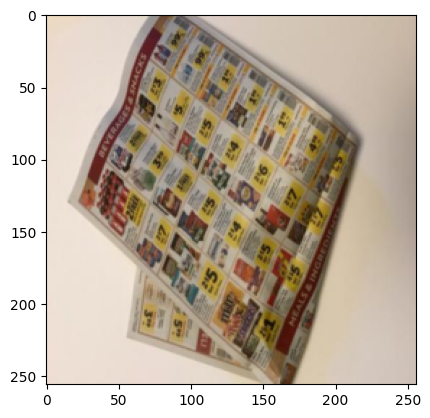

In [5]:
img, label = dataset[1500]
show_sample(img, label)

## Loading and Splitting Data

<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>Next, the dataset is split into training, validation, and test datasets. It's important to have separate sets for training the model, tuning the parameters (validation), and evaluating the model's performance (testing). A random seed is set for reproducibility, and the PyTorch utility random_split is used to split the dataset.</p>
</blockquote>

In [6]:
random_seed = 42
torch.manual_seed(random_seed)

In [7]:
len(dataset)

2527

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

## DataLoaders

<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>Data loaders are used to load the data in batches during the training process. It helps in efficient utilization of memory and can significantly speed up the training process.</p>
<ul>
<li><strong>Batch size (batch_size):</strong> This is the number of samples that will be passed through the model at once. The batch size can affect both the speed and the performance of the model. If the batch size is too large, it may not fit into memory; if it's too small, the training process can be slow, as the model needs to make updates after each batch. A batch size of 32 is a typical choice.</li>
<li><strong>Shuffle:</strong> The <code>shuffle</code> argument determines whether the data is shuffled at each epoch (a full pass through the entire dataset). Shuffling the training data is generally a good idea as it can prevent the model from learning the order of the data, which can be especially beneficial when the order of your samples can have an impact on the learning process.</li>
<li><strong>Number of workers (num_workers):</strong> This is the number of subprocesses to use for data loading. It can significantly impact the speed of data loading. <code>num_workers = 0</code> means that the data will be loaded in the main process, which can slow down training, especially for larger batch sizes. By setting <code>num_workers</code> to a number greater than zero, you can take advantage of multi-core CPUs to load data in parallel.</li>
<li><strong>Pin Memory (pin_memory):</strong> If <code>pin_memory=True</code>, the data loader will copy tensors into CUDA pinned memory before returning them. This can result in speedup when transferring data to the GPU during training because moving pinned (page-locked) memory is faster than un-pinned memory. However, it can consume more memory because it reserves the memory and it cannot be used for other purposes.</li>
</ul>
</blockquote>

In [9]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

###  Function to visualize batches

In [11]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

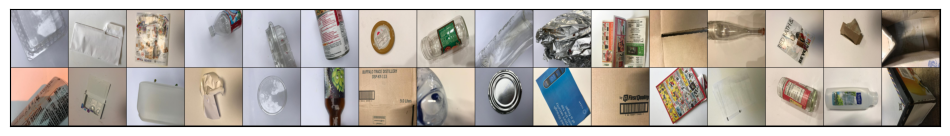

In [12]:
show_batch(train_dl)

## Model Defination

<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>The next step is to define the model. In this project, a Convolutional Neural Network (CNN) is utilized due to its efficiency in handling image data. The architecture of the model introduces the concept of residual learning to alleviate the problem of training very deep neural networks.</p>
<br>
<ol>
<li><strong>Accuracy function (accuracy(outputs, labels)):</strong> This function calculates the accuracy of the model's predictions by comparing the predicted labels (preds) with the actual labels (labels). It returns the accuracy as a tensor.</li><br>
<li><strong>ImageClassificationBase class:</strong> This is a base class that serves as a parent class for our model. It contains several methods for training and validation steps, as well as functions to calculate loss and accuracy.
<br>
<ul>
<li><code>training_step(self, batch):</code> This method takes a batch of images (images) and corresponding labels (labels) as input. It generates predictions (out) using the model, calculates the cross-entropy loss between the predictions and the labels (loss), and computes the accuracy using the accuracy function. The method returns a dictionary with the training loss and accuracy.</li>
<li><code>validation_step(self, batch):</code> Similar to training_step, this method calculates the loss and accuracy for the validation set.</li>
<li><code>validation_epoch_end(self, outputs):</code> This method takes a list of dictionaries containing the validation losses and accuracies for each batch and combines them to calculate the average loss and accuracy for the entire validation epoch. It returns a dictionary with the validation loss and accuracy.</li>
<li><code>epoch_end(self, epoch, result):</code> This method is called at the end of each epoch to print the training and validation loss, accuracy, and elapsed time. It takes the current epoch number (epoch) and a dictionary (result) containing the training and validation metrics as input.</li>
</ul>
</li>
</ol>
</blockquote>

In [34]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return {'train_loss': loss, 'train_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, time: {:.4f}s".format(
            epoch+1, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'], result['elapsed_time']))


<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>3. <strong>Bottleneck class:</strong> This class defines the "bottleneck" block used in the model architecture. It consists of a sequence of convolutional layers and batch normalization layers, along with a shortcut connection. The shortcut connection allows the network to bypass some layers and helps in avoiding the degradation problem associated with deep networks.</p>
<ul>
<li>The <code>__init__</code> method initializes the layers of the bottleneck block. It takes input channels (<code>in_channels</code>), output channels (<code>out_channels</code>), and stride as arguments. The convolutional layers and batch normalization layers are defined in the <code>residual_function</code>, and the shortcut connection is defined in the <code>shortcut</code> sequence. If the stride is not 1 or the number of input channels is not equal to <code>out_channels * Bottleneck.expansion</code>, the shortcut connection is defined to match the dimensions.</li>
<li>The <code>forward</code> method defines the forward pass of the bottleneck block. It applies the residual function to the input tensor <code>x</code> and adds the shortcut connection. The output is passed through a ReLU activation function.</li>
</ul>
</blockquote>

In [35]:
# Define the "Bottleneck" block
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * Bottleneck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * Bottleneck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * Bottleneck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * Bottleneck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * Bottleneck.expansion)
            )
        
    def forward(self, x):
        return F.relu(self.residual_function(x) + self.shortcut(x))

<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>4. <strong>CNN class:</strong> This class represents the overall CNN model. It is derived from the <code>ImageClassificationBase</code> class and consists of multiple convolutional blocks.</p>
<ul>
<li>The <code>__init__</code> method initializes the layers of the CNN model. It takes a block type (<code>block</code>), a list of numbers representing the number of blocks in each stage (<code>num_block</code>), and the number of output classes (<code>num_classes</code>) as arguments. The CNN model consists of several convolutional layers (<code>conv1</code>, <code>conv2_x</code>, <code>conv3_x</code>, <code>conv4_x</code>, <code>conv5_x</code>), pooling layers (<code>maxpool</code>), an adaptive average pooling layer (<code>avg_pool</code>), and a fully connected layer (<code>fc</code>). The convolutional blocks are created using the <code>_make_layer</code> method.</li>
<li>The <code>_make_layer</code> method creates a sequence of bottleneck blocks with the given parameters. It takes a block type (<code>block</code>), the number of output channels (<code>out_channels</code>), the number of blocks (<code>num_blocks</code>), and the stride value as arguments. It initializes the blocks in a sequential manner and updates the number of input channels accordingly.</li>
<li>The <code>forward</code> method defines the forward pass of the CNN model. It applies the convolutional and pooling layers in a sequential manner and then passes the output through the adaptive average pooling layer. The output is reshaped and passed through the fully connected layer to generate the final predictions.</li>
</ul>
</blockquote>

In [36]:
# Define the CNN model
class CNN(ImageClassificationBase):
    def __init__(self, block, num_block, num_classes=len(dataset.classes)):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.maxpool(output)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return torch.sigmoid(output)

<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>5. <strong>`cnn()` function:</strong> This function creates an instance of the CNN model with the desired block type (`Bottleneck`), the number of blocks in each stage (`[3, 4, 6, 3]`), and the number of output classes (defaulting to the number of classes in the dataset).</p>
<p>6. <strong>Creating the model instance:</strong> Finally, an instance of the CNN model is created using the `cnn()` function.</p>
</blockquote>

In [37]:
def cnn():
    return CNN(Bottleneck, [3, 4, 6, 3])

model = cnn()

for param in model.parameters():
    param.requires_grad = True

## Moving the Model to the Device

<blockquote style="background-color: #f4f4f4; padding: 10px; border-left: 4px solid #2b7cff;">
<p>To speed up the computations, we move our model to the GPU if one is available. If not, the model will run on the CPU. The <code>torch.cuda.is_available()</code> function is used to check the availability of a GPU.</p>
</blockquote>

In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [39]:
device = get_default_device()
device

device(type='cpu')

In [40]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): Bottleneck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

## Training the model

In [41]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        start_time = time.time()  # Get current time
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []     # store accuracies for each batch
        for batch in train_loader:
            output = model.training_step(batch)
            train_losses.append(output['train_loss'])
            train_accs.append(output['train_acc'])  # append accuracy
            output['train_loss'].backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()  # Calculate the average training accuracy over the epoch
        end_time = time.time()  # Get current time after completing epoch
        elapsed_time = end_time - start_time  # Calculate elapsed time
        result['elapsed_time'] = elapsed_time
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [42]:
model = to_device(cnn(), device)

In [32]:
evaluate(model, val_dl)

{'val_loss': 1.7920054197311401, 'val_acc': 0.0746527761220932}

In [43]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 9.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.5916, train_acc: 0.3627, val_loss: 1.6885, val_acc: 0.3958, time: 1011.5445s
Epoch 2: train_loss: 1.4704, train_acc: 0.4407, val_loss: 1.5413, val_acc: 0.4097, time: 1206.0960s
Epoch 3: train_loss: 1.4240, train_acc: 0.5169, val_loss: 1.4290, val_acc: 0.5312, time: 749.0367s
Epoch 4: train_loss: 1.3864, train_acc: 0.5717, val_loss: 1.3993, val_acc: 0.5052, time: 765.0005s
Epoch 5: train_loss: 1.3579, train_acc: 0.6108, val_loss: 1.4292, val_acc: 0.4965, time: 757.2305s
Epoch 6: train_loss: 1.3289, train_acc: 0.6547, val_loss: 1.5083, val_acc: 0.4931, time: 753.1100s
Epoch 7: train_loss: 1.3043, train_acc: 0.7125, val_loss: 1.4012, val_acc: 0.6354, time: 751.4316s
Epoch 8: train_loss: 1.2768, train_acc: 0.7353, val_loss: 1.3912, val_acc: 0.6198, time: 760.6508s
Epoch 9: train_loss: 1.2557, train_acc: 0.7686, val_loss: 1.4334, val_acc: 0.5521, time: 761.7068s
Epoch 10: train_loss: 1.2489, train_acc: 0.7804, val_loss: 1.4410, val_acc: 0.5625, time: 756.6623s
Epoch 1

## Model Evaluation

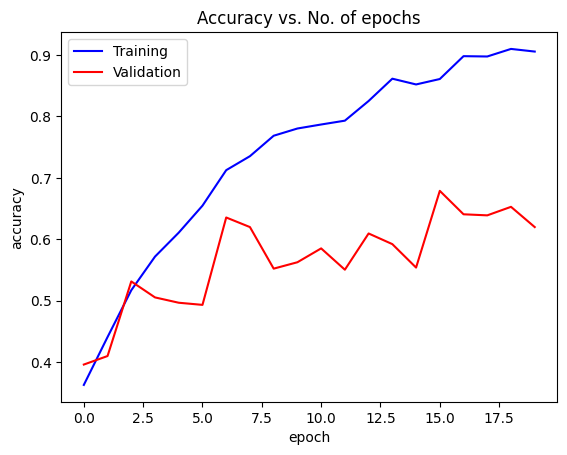

In [53]:
def plot_accuracies(history):
    train_acc = [x.get('train_acc') for x in history]
    val_acc = [x['val_acc'] for x in history]
    plt.plot(train_acc, '-b')
    plt.plot(val_acc, '-r')
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'])
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


plot_accuracies(history)

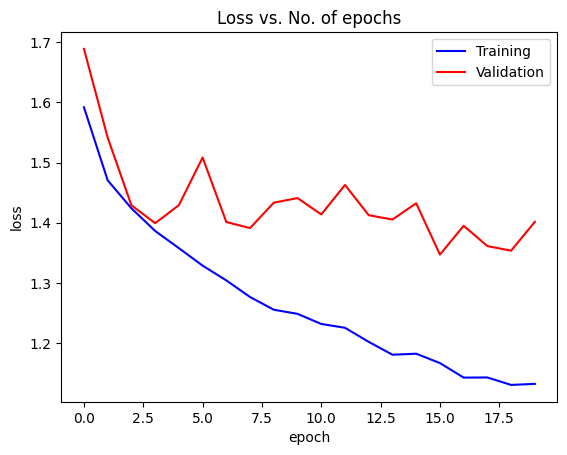

In [54]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

## Making Predictions

In [55]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


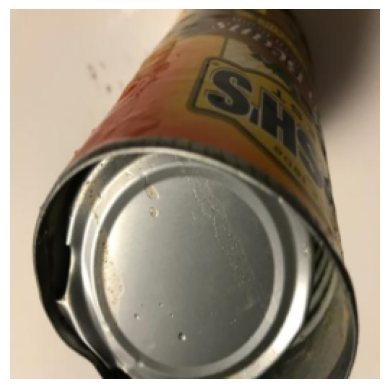

In [56]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


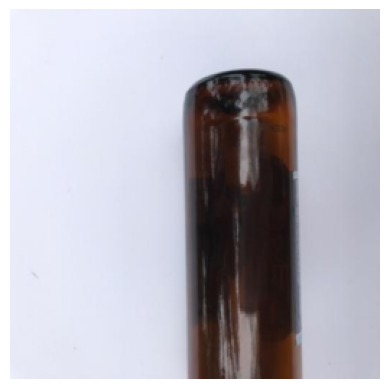

In [57]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


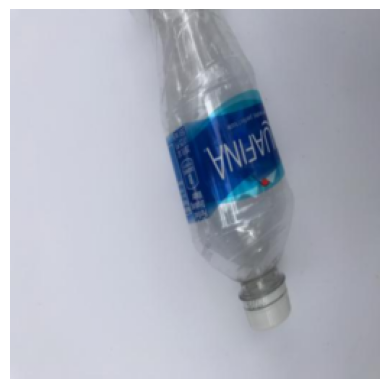

In [58]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

## Saving the Model

In [59]:
# Model Save
torch.save(model.state_dict(), 'Garbage_Model.pth')

## Hyperparameter Tuning

In [66]:
# Define the hyperparameters that we want to tune: number of epochs, optimizer function, and learning rate.
num_epochs = [3, 5, 8]
opt_funcs = [torch.optim.SGD, torch.optim.Adam]
lrs = [1.5e-5, 5.5e-5, 9.5e-5]

In [67]:
# Define the grid search function.
def grid_search(num_epochs, opt_funcs, lrs):
    # Initialize best accuracy to 0. This will store the highest accuracy we find.
    best_accuracy = 0
    # Initialize an empty dictionary to store the best hyperparameters.
    best_hyperparams = {}
    
    # Iterate over all the possible combinations of hyperparameters.
    for epoch in num_epochs:
        for opt_func in opt_funcs:
            for lr in lrs:
                # For each combination, initialize a new model and move it to the device (CPU or GPU).
                model = to_device(cnn(), device)
                # Print the hyperparameters being used for this training round.
                print(f"Training for epochs={epoch}, optimizer={opt_func.__name__}, learning_rate={lr}")
                # Fit the model with the current combination of hyperparameters.
                history = fit(epoch, lr, model, train_dl, val_dl, opt_func)
                # Retrieve the accuracy from the last epoch of training.
                accuracy = history[-1]['val_acc'] 
                
                # If the accuracy from this round is greater than our current best accuracy,
                # update best accuracy and best hyperparameters.
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_hyperparams = {
                        'num_epochs': epoch,
                        'optimizer': opt_func.__name__,
                        'learning_rate': lr
                    }
    
    # Return the best hyperparameters and the best accuracy.
    return best_hyperparams, best_accuracy

In [68]:
# Run the grid search function with our defined hyperparameters.
best_hyperparams, best_accuracy = grid_search(num_epochs, opt_funcs, lrs)

# Print the best hyperparameters and the corresponding best validation accuracy.
print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best validation accuracy: {best_accuracy}")

Training for epochs=3, optimizer=SGD, learning_rate=1.5e-05
Epoch 1: train_loss: 1.8146, train_acc: 0.1554, val_loss: 1.8028, val_acc: 0.1736, time: 810.2150s
Epoch 2: train_loss: 1.8119, train_acc: 0.1531, val_loss: 1.8091, val_acc: 0.1840, time: 781.1154s
Epoch 3: train_loss: 1.8088, train_acc: 0.1555, val_loss: 1.8085, val_acc: 0.1736, time: 786.6642s
Training for epochs=3, optimizer=SGD, learning_rate=5.5e-05
Epoch 1: train_loss: 1.7728, train_acc: 0.1571, val_loss: 1.7726, val_acc: 0.1788, time: 821.6067s
Epoch 2: train_loss: 1.7654, train_acc: 0.1578, val_loss: 1.7645, val_acc: 0.1788, time: 783.8903s
Epoch 3: train_loss: 1.7590, train_acc: 0.1575, val_loss: 1.7594, val_acc: 0.1788, time: 781.0966s
Training for epochs=3, optimizer=SGD, learning_rate=9.5e-05
Epoch 1: train_loss: 1.7873, train_acc: 0.1828, val_loss: 1.7863, val_acc: 0.2361, time: 784.0364s
Epoch 2: train_loss: 1.7729, train_acc: 0.2303, val_loss: 1.7759, val_acc: 0.2153, time: 774.2092s
Epoch 3: train_loss: 1.7622,

RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 33554432 bytes.